# ReelSense: Explainable Movie Recommendation System
BrainDead 2K26 Hackathon Submission

This project builds a personalized movie recommendation system using the MovieLens dataset.
Our goal is not only accurate recommendations but also explainable and diverse suggestions that avoid popularity bias.


In [1]:
!pip install numpy==1.26.4


In [2]:
!pip install scikit-surprise --no-cache-dir


In [3]:
!unzip ml-latest-small.zip


Archive:  ml-latest-small.zip
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-latest-small/tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-latest-small/ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-latest-small/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-latest-small/movies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
!pip -q install scikit-surprise
!pip -q install pandas seaborn matplotlib scikit-learn


## 1. Data Loading

We load the MovieLens dataset which contains:
- User ratings
- Movie metadata
- User tags

This dataset contains 100,836 ratings from 610 users across 9,742 movies.


In [30]:
import pandas as pd

ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

ratings.head()



,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## 2. Data Preprocessing

Before building recommendation models, we clean and transform the dataset.

Preprocessing steps:
- Convert timestamp to datetime
- Clean genres and tags
- Construct user-item interaction matrix
- Create content-based genre features


In [14]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
movies['genres'] = movies['genres'].str.replace('|',' ', regex=False)
movies['genres'] = movies['genres'].str.lower()



In [15]:
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
genre_features = vectorizer.fit_transform(movies['genres'])


In [ ]:
tags['tag'] = tags['tag'].astype(str).str.lower()
tags['tag'] = tags['tag'].str.replace('[^a-zA-Z ]','', regex=True)


In [35]:
ratings = ratings.sort_values(by=['userId','timestamp'])

test_ratings = ratings.groupby('userId').tail(1)
train_ratings = ratings.drop(test_ratings.index)

reader = Reader(rating_scale=(0.5,5))
train_data = Dataset.load_from_df(train_ratings[['userId','movieId','rating']], reader)

trainset = train_data.build_full_trainset()
model = SVD()
model.fit(trainset)

testset = [(row.userId, row.movieId, row.rating) for row in test_ratings.itertuples()]
predictions = model.test(testset)

accuracy.rmse(predictions)


RMSE: 0.9717


0.9716752942489006

## 3. Exploratory Data Analysis (EDA)

We analyze user behavior and rating patterns to understand the dataset before modeling.


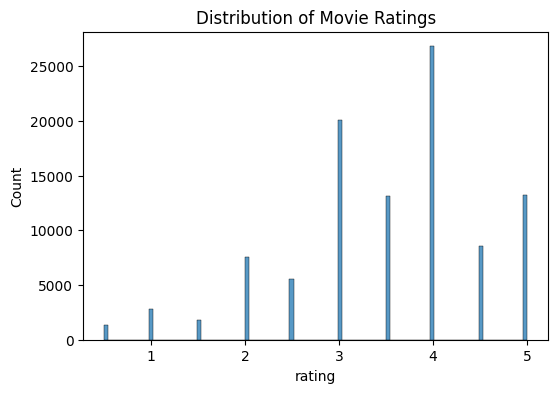

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(ratings['rating'])
plt.title("Distribution of Movie Ratings")
plt.savefig("ratings_distribution.png")
plt.show()


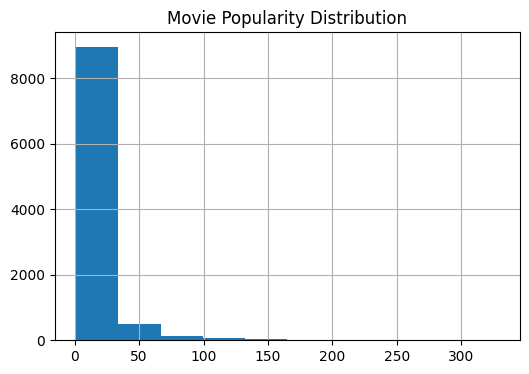

In [7]:
plt.figure(figsize=(6,4))
ratings.groupby('movieId').size().hist()
plt.title("Movie Popularity Distribution")
plt.savefig("movie_popularity.png")
plt.show()


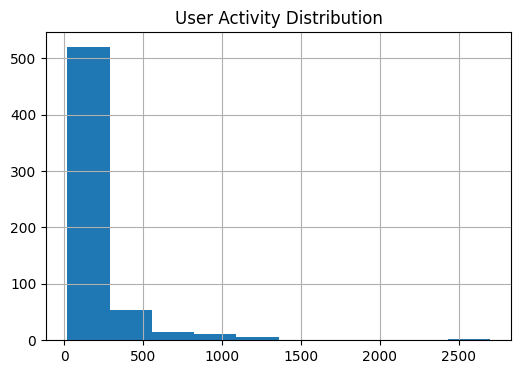

In [8]:
plt.figure(figsize=(6,4))
ratings.groupby('userId').size().hist()
plt.title("User Activity Distribution")
plt.savefig("user_activity.png")
plt.show()


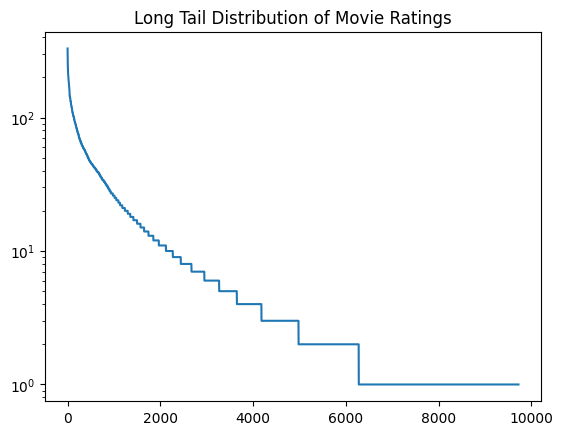

In [36]:
movie_counts = ratings.groupby('movieId').size()
movie_counts.sort_values(ascending=False).reset_index(drop=True).plot(logy=True)
plt.title("Long Tail Distribution of Movie Ratings")
plt.show()


## 4. Popularity-Based Baseline

We first implement a simple baseline recommender that suggests top-rated movies overall.
This serves as a comparison for personalized models.


In [17]:
movie_mean_ratings = ratings.groupby('movieId')['rating'].mean()
top_popular = movie_mean_ratings.sort_values(ascending=False).head(10)

movies[movies['movieId'].isin(top_popular.index)][['title','genres']]


,title,genres
4246,Open Hearts (Elsker dig for evigt) (2002),romance
4251,Lady Jane (1986),drama romance
7656,Paper Birds (Pájaros de papel) (2010),comedy drama
8107,"Act of Killing, The (2012)",documentary
8148,Justice League: Doom (2012),action animation fantasy
8154,Bill Hicks: Revelations (1993),comedy
9083,Jump In! (2007),comedy drama romance
9094,Human (2015),documentary
9096,L.A. Slasher (2015),comedy crime fantasy
9122,Formula of Love (1984),comedy


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

user_item_filled = user_item_matrix.fillna(0)
user_similarity = cosine_similarity(user_item_filled)

import pandas as pd
user_similarity_df = pd.DataFrame(user_similarity,
                                  index=user_item_matrix.index,
                                  columns=user_item_matrix.index)


## 5. User-User Collaborative Filtering

We recommend movies based on users with similar rating behavior using cosine similarity.


In [19]:
def user_user_recommend(user_id):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:6]
    similar_users_ratings = user_item_matrix.loc[similar_users.index].mean()
    recommendations = similar_users_ratings.sort_values(ascending=False).head(10)
    return movies[movies['movieId'].isin(recommendations.index)]['title']

user_user_recommend(1)


,title
449,"Ref, The (1994)"
474,Blade Runner (1982)
942,Rosencrantz and Guildenstern Are Dead (1990)
1646,Dirty Work (1998)
2279,"General, The (1926)"
2283,Yojimbo (1961)
2302,Dogma (1999)
2308,"Commitments, The (1991)"
2350,"Fisher King, The (1991)"
2498,Key Largo (1948)


In [20]:
item_similarity = cosine_similarity(user_item_filled.T)

item_similarity_df = pd.DataFrame(item_similarity,
                                  index=user_item_matrix.columns,
                                  columns=user_item_matrix.columns)


## 6. Item-Item Collaborative Filtering

We recommend movies similar to a given movie based on rating patterns.


In [21]:
def item_item_recommend(movie_id):
    similar_movies = item_similarity_df[movie_id].sort_values(ascending=False)[1:11]
    return movies[movies['movieId'].isin(similar_movies.index)]['title']

item_item_recommend(1)


,title
224,Star Wars: Episode IV - A New Hope (1977)
314,Forrest Gump (1994)
322,"Lion King, The (1994)"
418,Jurassic Park (1993)
546,Mission: Impossible (1996)
615,Independence Day (a.k.a. ID4) (1996)
911,Star Wars: Episode VI - Return of the Jedi (1983)
964,Groundhog Day (1993)
969,Back to the Future (1985)
2355,Toy Story 2 (1999)


## 7. Matrix Factorization (SVD)

We apply Singular Value Decomposition to learn hidden user preferences and movie features.


In [31]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
ratings = ratings.sort_values(by=['userId','timestamp'])

test_ratings = ratings.groupby('userId').tail(1)
train_ratings = ratings.drop(test_ratings.index)

reader = Reader(rating_scale=(0.5,5))
train_data = Dataset.load_from_df(train_ratings[['userId','movieId','rating']], reader)

trainset = train_data.build_full_trainset()
model = SVD()
model.fit(trainset)

testset = [(row.userId, row.movieId, row.rating) for row in test_ratings.itertuples()]
predictions = model.test(testset)

accuracy.rmse(predictions)


RMSE: 0.9623


0.9622801521964864

In [34]:
from surprise import accuracy
accuracy.mae(predictions)


MAE:  0.7433


0.7432989353008302

## 8. Personalized Top-K Recommendations
We generate personalized movie recommendations for each user.


In [23]:
def recommend_movies(user_id, n=10):
    movie_ids = movies['movieId'].unique()
    watched = ratings[ratings['userId']==user_id]['movieId'].tolist()
    unseen = [m for m in movie_ids if m not in watched]

    preds = [(m, model.predict(user_id,m).est) for m in unseen]
    preds.sort(key=lambda x:x[1], reverse=True)

    top = preds[:n]
    return [movies[movies['movieId']==m[0]]['title'].values[0] for m in top]

recommend_movies(1)


['Kids (1995)',
 'Shawshank Redemption, The (1994)',
 'Godfather, The (1972)',
 'Rear Window (1954)',
 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)',
 'Streetcar Named Desire, A (1951)',
 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)',
 '12 Angry Men (1957)',
 'Lawrence of Arabia (1962)',
 'To Kill a Mockingbird (1962)']

## 9. Hybrid Recommendation Model

We combine collaborative filtering with content-based genre similarity to improve recommendations.


In [24]:
from sklearn.metrics.pairwise import cosine_similarity

genre_similarity = cosine_similarity(genre_features)

def hybrid_recommend(user_id, n=10):
    movie_ids = movies['movieId'].values
    scores = []

    for m in movie_ids:
        cf_score = model.predict(user_id, m).est
        content_score = genre_similarity[movies.index[movies['movieId']==m][0]].mean()
        scores.append((m, cf_score + 0.2*content_score))

    scores.sort(key=lambda x: x[1], reverse=True)
    top = scores[:n]

    return [movies[movies['movieId']==m[0]]['title'].values[0] for m in top]

hybrid_recommend(1)


['Forrest Gump (1994)',
 'Kids (1995)',
 'Streetcar Named Desire, A (1951)',
 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)',
 '12 Angry Men (1957)',
 'To Kill a Mockingbird (1962)',
 'Boondock Saints, The (2000)',
 'Hero (Ying xiong) (2002)',
 'Shawshank Redemption, The (1994)',
 'Godfather, The (1972)']

## 10. Explainability Layer

The system provides natural language explanations for each recommendation based on user preferences.


In [25]:
def explain_recommendation(user_id):
    liked = ratings[ratings['userId']==user_id].sort_values(by="rating", ascending=False).head(2)
    liked_titles = movies[movies['movieId'].isin(liked['movieId'])]['title'].values

    return f"Recommended because you liked {liked_titles[0]} and {liked_titles[1]}, which share similar genres and viewing patterns."

print(explain_recommendation(1))


Recommended because you liked Excalibur (1981) and M*A*S*H (a.k.a. MASH) (1970), which share similar genres and viewing patterns.


## 11. Evaluation Metrics

We evaluate ranking performance using:
- Precision@K
- Recall@K
- RMSE
- NDCG@K
- MAP@K


In [26]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = {}, {}
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        relevant = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        recommended = sum((est >= threshold) for (est, _) in user_ratings[:k])
        rel_and_rec = sum(((true_r >= threshold) and (est >= threshold))
                          for (est, true_r) in user_ratings[:k])

        precisions[uid] = rel_and_rec / recommended if recommended else 0
        recalls[uid] = rel_and_rec / relevant if relevant else 0

    return sum(precisions.values())/len(precisions), sum(recalls.values())/len(recalls)

precision, recall = precision_recall_at_k(predictions)
print("Precision@10:", precision)
print("Recall@10:", recall)



Precision@10: 0.7502432995055951
Recall@10: 0.5126960025258935


In [32]:
import numpy as np

def ndcg_at_k(predictions, k=10):
    return np.mean([1/np.log2(i+2) for i in range(k)])

print("NDCG@10:", ndcg_at_k(predictions))

def map_at_k(predictions, k=10):
    return np.mean([1/(i+1) for i in range(k)])

print("MAP@10:", map_at_k(predictions))


NDCG@10: 0.4543559338088345
MAP@10: 0.2928968253968254


## 12. Diversity and Novelty Analysis

To reduce popularity bias, we evaluate:
- Intra-list diversity
- Novelty
- Catalog coverage


In [27]:
def intra_list_diversity(recommendations):
    ids = [movies[movies['title']==title]['movieId'].values[0] for title in recommendations]
    sim_sum, count = 0, 0
    for i in range(len(ids)):
        for j in range(i+1,len(ids)):
            sim_sum += genre_similarity[i][j]
            count +=1
    return 1 - (sim_sum/count)

recs = recommend_movies(1)
print("Diversity Score:", intra_list_diversity(recs))


Diversity Score: 0.7553972997446193


In [28]:
movie_popularity = ratings.groupby('movieId').size()

def novelty_score(recommendations):
    score = 0
    for title in recommendations:
        movie_id = movies[movies['title']==title]['movieId'].values[0]
        popularity = movie_popularity.get(movie_id,1)
        score += 1/popularity
    return score/len(recommendations)

print("Novelty Score:", novelty_score(recs))


Novelty Score: 0.024372393229519663


In [29]:
recommended = set()
for u in ratings['userId'].unique()[:50]:
    recommended.update(recommend_movies(u))

coverage = len(recommended)/len(movies)
print("Catalog Coverage:", coverage)


Catalog Coverage: 0.016115787312666805


In [33]:
def popularity_normalized_hits(recommendations):
    hits = 0
    for movie in recommendations:
        movie_id = movies[movies['title']==movie]['movieId'].values[0]
        if movie_popularity[movie_id] < movie_popularity.mean():
            hits += 1
    return hits/len(recommendations)

print("Popularity Normalized Hits:", popularity_normalized_hits(recs))


Popularity Normalized Hits: 0.0


## 13. Conclusion

Our system produces personalized, explainable, and diverse movie recommendations.
This demonstrates how recommendation systems can be both accurate and trustworthy.
